## To run the code, make sure that you have the correct file structure:

1. Create a folder where you would like the to hold all of the data for analysis, which includes the images, metadata, and where to put the results. Keep track of this file path, you will be asked to provide it to perform the analysis.
2. Create a sub-folder for all of you images and name it "Images'
3. Create another sub-folder for the results and name it "automated_results"
4. If you are analyzing a batch of images, create a folder named 'metadata' and place your image and batch metadata here.


#### Load Libraries

In [1]:
import pandas as pd
import time
import skimage
from skimage import io
from skimage import filters
from skimage import feature
from skimage import morphology
from skimage import measure
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib as plb 
import csv

### Functions for Image Analysis

#### Load data


In [50]:
# Setting up the file path and reading in the image to be analyzed

def load_image_data(data_location, prefix, image_num):

    
    fin_file = data_location.joinpath(prefix + '_' +  image_num + '_POST.tif' )
    fin_image = skimage.io.imread(fin_file)

    return fin_image



In [52]:
# This function is only invoked when processing a batch of images. It collects the plate
# id from the metadata.  Still need to incorporate the compound info into the metadata
# sheet and collection will happen here

def get_plate_id(slot, image_pointer, img_metdat):
    file_name = image_pointer.resolve().stem[:] + '.tif'

    if slot == 1:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot1_plate', 'slot1_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 2:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot2_plate', 'slot2_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 3:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot3_plate', 'slot3_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 4:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot4_plate', 'slot4_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
        
    return plate, compound


In [53]:
# This is only invoked when processing a batch of assays
# The strain that is placed is in each well is captured in the metadata and collected here
# for the analysis
def get_strain(prefix, well_id, batch_dat):
    if well_id == 'P':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellP']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'Q':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellQ']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'R':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellR']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'S':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellS']].values.flatten().tolist()
        strain = strain_l[0]
        
    return strain

## Cropping images
1. Cropping to individual plates
2. Cropping to individual wells.
3. The location of the plates on the scanner has important implications to how the wells are cropped. The outer edges of the plates have more 'dead' space in the images and need to be cropped to avoid bias relative to the center of the plate.

In [54]:
# TO be replaced by Ehsan's autocropping code

def crop_to_one_plate(fin_image, slot_id):

    # select bounds of the slot we're working on now
    if slot_id == 1:
        upper_boundary = 760
        lower_boundary = 6786
        left_boundary = 5440
        right_boundary = 9444
    elif slot_id == 2:
        upper_boundary = 760
        lower_boundary = 6786
        left_boundary = 784 
        right_boundary = 4788
    elif slot_id == 3:
        upper_boundary = 7480
        lower_boundary = 13506
        left_boundary = 784
        right_boundary = 4788
    elif slot_id == 4:
        upper_boundary = 7480
        lower_boundary = 13506
        left_boundary = 5440
        right_boundary = 9444
    else:
        raise ValueError('Lane label not recognized.')

    fin_image = fin_image[upper_boundary:lower_boundary, left_boundary:right_boundary]
    
    return fin_image



In [6]:
# To account for the dead space and correct insure that the CI is being calculated the same
# for the left and right side plates, we need to crop them a little differently.
# This will be replaced by auto cropping

def left_crop_to_one_well(fin_image, well_id):
    # select bounds of the lane we're working on now
    Left_boundary = 300
    Right_boundary = 3724
    if well_id == 'P':
        Upper_boundary = 265
        Lower_boundary = 1415
    elif well_id == 'Q':
        Upper_boundary = 1725
        Lower_boundary = 2875
    elif well_id == 'R':
        Upper_boundary = 3165
        Lower_boundary = 4315
    elif well_id == 'S':
        Upper_boundary = 4615
        Lower_boundary = 5765
    fin_image = fin_image[ Upper_boundary:Lower_boundary ,Left_boundary:Right_boundary ]

    
    # Crop larger image to make before and after images the same size
    #x_min = 0
    #x_max = fin_image.shape[1]
    
    #y_min = 100
    #y_max = 3790 # min(pre_image.shape[0], fin_image.shape[0])
    
    #fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return fin_image

def right_crop_to_one_well(fin_image, well_id):
    # select bounds of the lane we're working on now
    Left_boundary = 190
    Right_boundary = 3614
    if well_id == 'P':
        Upper_boundary = 265
        Lower_boundary = 1415
    elif well_id == 'Q':
        Upper_boundary = 1725
        Lower_boundary = 2875
    elif well_id == 'R':
        Upper_boundary = 3165
        Lower_boundary = 4315
    elif well_id == 'S':
        Upper_boundary = 4615
        Lower_boundary = 5765
    fin_image = fin_image[ Upper_boundary:Lower_boundary , Left_boundary:Right_boundary ]
    
    return fin_image


### Find worms

In [7]:
def find_worms(fin_image):
    feature_find_start = time.time()
    
    ## Threshold to get binary image
    thresh = skimage.filters.threshold_li(fin_image)
    binarized = fin_image > thresh

    ## Find features in binary image
    labeled_array, num_features = ndi.label(binarized)
    all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
                                      coordinates='rc')

    filtered_regions = []
    for region in all_regions:
        area = region.area

        if area >= 90 and area <=1000 and region.major_axis_length < 150:
            filtered_regions.append(region)
            #print(area)
            
#     print('Worm finding and filtering took', str(int(time.time() - feature_find_start)), 'seconds.')
    return filtered_regions

### Save worm locations

In [8]:
def save_worm_locations(filename, worms):
    with open(filename, 'w', newline='') as csvfile:
        worm_writer = csv.writer(csvfile, delimiter=',')
        worm_writer.writerow([' ','X','Y']) # header row

        worm_num = 1
        for worm in worms:
            worm_writer.writerow([worm_num, worm.centroid[1], worm.centroid[0]])
            worm_num += 1

### Calculate Chemotaxis Index

In [9]:
def calc_chemotaxis_index(worm_regions):
   
    ## Assign features to zones of the plate
    left_area_boundary = int(3424*4/9) #8000
    right_area_boundary = int(3424*5/9)

    left_side_worms = [worm for worm in worm_regions if worm.centroid[1] <= left_area_boundary]
    middle_worms = [worm for worm in worm_regions 
                    if worm.centroid[1] > left_area_boundary and worm.centroid[1] < right_area_boundary]
    right_side_worms = [worm for worm in worm_regions if worm.centroid[1] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(worm_regions)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))
    
    chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
  
    x_coords = []
    y_coords = []
    for worm in worm_regions:
#         x_sum += worm.centroid[0]
#         y_sum += worm.centroid[1]
        x_coords.append(worm.centroid[0])
        y_coords.append(worm.centroid[1])

    centroid = (sum(x_coords)/len(x_coords), sum(y_coords)/len(y_coords))

    return chemotaxis_index, centroid

In [10]:
# Currently not being invoked. but here in case we want to plot

def plot_worms(df, fin_image):

    fig, ax = plt.subplots(figsize=(5, 10))

    ax.imshow(fin_image)#[y_min:y_max, x_min:x_max])
    ax.set_title('Worm Locations' +prefix + '_' + plate_id + '_'+ well_id)
    for index, row in df.iterrows():
        minr, minc, maxr, maxc = row['bbox']

        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=.5)
        ax.add_patch(rect)
        
    #fig.savefig('../test_figures/' + prefix + plate_id + well_id +'.jpg')
#    cv2.imwrite('../test_figures/' + plate_id + well_id +'.jpg', fig)

## Code for anylizing a single image

In [11]:
# Only invoked for single image analysis. We have the option to capture compound and strain
# info. These have been commented out to do a simple count and CI capture.

class Plate_info:
    def __init__(self, slot, pID):
        self.slot = slot
        self.pID = pID
        #self.compound = compound
        #self.wellP = strainP
        #self.wellQ = strainQ
        #self.wellR = strainR
        #self.wellS = strainS


In [65]:
# Only invoked for single image analysis. We have the option to capture compound and strain
# info. These have been commented out to do a simple count and CI capture.
def capture_data(snum):
    data = Plate_info(snum, input('Enter plate ID: ')) 
                      #input('Enter compound applied to plate: '),
                      #input('Enter strain in well P: '),
                      #input('Enter strain in well Q: '),
                      #input('Enter strain in well R: '),
                      #input('Enter strain in well S: '))
    data = data.__dict__
    return data

In [66]:
# The user is asked if there are plates present in all of the slots. If a plate is missing
# from one of the slots, the code ignores the slot and doesn't waste computational energy trying
# to count "nothing"

def one_image_metdat():
    slots = {}
    for i in range(1,5):
        num = i
        check = user_input(num)
        if check == 'n' or check == 'no':
            break
        else:
            slots[i] = check
    return slots



In [67]:
def user_input(snum):
    answer = input('Is there a plate in slot %d? ' %snum).lower()
    if answer == 'y' or answer == 'yes':
        info = capture_data(snum)
        return info
    elif answer == 'n' or answer == 'no':
        return answer
    else:
        print('Please enter a valid response')
        return user_input(snum)
        


In [68]:
def quick_process(img, auto_loc, metdat):
    
    loop_start = time.time()
    results = []
    bins = 9
    image_id = img.stem


    # Load the entire image
    fin_image = skimage.io.imread(img)
#    print('Image load took', str(int(time.time()-plate_start)), 'seconds.')


    for i in range(len(metdat)):
        slot_id = i + 1
        plate_id = metdat[slot_id]['pID']
        fin_cropped_2plate = crop_to_one_plate(fin_image, slot_id) 
        #plate_id, compound = get_plate_id(slot_id, path, img_metdat)

        results_list = []
        for well_id in ['P', 'Q', 'R', 'S']:
            # Process one well at a time
            if slot_id == 1 or slot_id == 4:
                cropped_fin_image = right_crop_to_one_well(fin_cropped_2plate, well_id)
            elif slot_id == 2 or slot_id == 3:
                cropped_fin_image = left_crop_to_one_well(fin_cropped_2plate, well_id)
            
            worms = find_worms(cropped_fin_image)
            total_worms = len(worms)
            # Save the results
            filename = auto_loc.joinpath(image_id + '_' + plate_id + '_' + well_id + '_automatedCounts' + '.csv')
            save_worm_locations(filename, worms)

            # Calculate chemotaxis index and gather into a dataframe
            if total_worms == 0:
                chemotaxis_index = 'NA'
                results_dict = {
                            'Well_id': well_id,
                            'Plate_id': plate_id,
                            'Total_Worms' : total_worms,
                            'Bin#' : bins,
                            'chemotaxis_index': chemotaxis_index,
                            'centroid_x': centroid[1],
                            'centroid_y': centroid[0]}
                results_list.append(results_dict)
                results.append(results_dict)

                props = ['area', 'convex_area', 'bbox', 'centroid']
                worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

            else:

                chemotaxis_index, centroid = calc_chemotaxis_index(worms)
                results_dict = {
                                'Well_id': well_id,
                                'Plate_id': plate_id,
                                'Total_Worms' : total_worms,
                                'Bin#' : bins,
                                'chemotaxis_index': chemotaxis_index,
                                'centroid_x': centroid[1],
                                'centroid_y': centroid[0]}
                results_list.append(results_dict)
                results.append(results_dict)

                props = ['area', 'convex_area', 'bbox', 'centroid']
                worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

                #plot_worms(worm_df, cropped_fin_image)

            #print('Finished', plate_id,'in', str(int(time.time()-plate_start)), 'seconds.')
    all_results_df = pd.DataFrame(results)
    all_results_df.to_csv(path_or_buf=auto_loc.joinpath(image_id + '_analysis_summary.csv'))
   #print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')



In [69]:
def process_one_image():
    current_dir = plb.Path(input('Enter the path to the folder containing the data to be analyzed:\n'))

    
    automated_results_location = current_dir.joinpath('automated_results')

    
    image_location = current_dir.joinpath('Images')

    
    image = image_location.joinpath(input('Enter the name of the image file to be analyzed:\n'))
  
    metadata = one_image_metdat()
    
    quick_process(image, automated_results_location, metadata)
    


## Process a batch of images


#### Establish location of metadata and load in the data

In [70]:
def process_all_imgs():
  # Create directory to store results to insure that naming conventions are consistent
    current_dir = plb.Path(input('Enter the file path to the folder containing the images and metadata to be analyzed: '))

    
    automated_results_location = current_dir.joinpath('automated_results')
    automated_results_location.mkdir(exist_ok=True, parents=True)

    
    image_location = current_dir.joinpath('Images')
    metadata_location = current_dir.joinpath('metadata')

    image_metadata_fname = input('Please enter the filename for the image metadata: ')


    batch_metdata_fname = input('Please enter the filename for the batch metadata: ')


    image_metadata_path = metadata_location.joinpath(image_metadata_fname)
    batch_metdata_path = metadata_location.joinpath(batch_metdata_fname)


    image_metadata = pd.read_csv(image_metadata_path)
    batch_metadata = pd.read_csv(batch_metdata_path)

    image_metadata.rename(columns={'Name of individual capturing image:': 'imager',
                       'Date:': 'date',
                       "Image file name:": 'filename',
                       'Is this the pre or post assay image?': 'pre_fin',
                      'Plate number in slot 1:': 'slot1_plate',
                       'Plate number in slot 2:': 'slot2_plate',
                       'Plate number in slot 3:': 'slot3_plate',
                       'Plate number in slot 4:': 'slot4_plate', 
                                 'Compound in slot 1:': 'slot1_compound', 
                                 'Compound in slot 2:': 'slot2_compound', 
                                 'Compound in slot 3:': 'slot3_compound', 
                                 'Compound in slot 4:': 'slot4_compound',}, inplace=True)

    batch_metadata.rename(columns={'Recorder\'s Name:': 'recorder',
                                'Date:': 'date',
                                 'Temperature:': 'temp',
                                'Humidity:': 'humidity',
                                'Date chemotaxis plates were poured:': 'plates_poured',
                                'Worm Strain in Well P:': 'strain_wellP',
                                'Worm Strain in Well Q:.1': 'strain_wellQ',
                                'Worm Strain in Well R:.1': 'strain_wellR',
                                'Worm Strain in Well S:.1': 'strain_wellS',
                                'dates' : 'dates_modified',}, inplace = True )
    batch_metadata['dates_modified'] = batch_metadata['dates_modified'].astype(str)





    return image_location, metadata_location, image_metadata, batch_metadata, automated_results_location

#if __name__ == "__main__":
#        main()

#### Loop through all of the images in the 'Images' folder.

In [71]:
def run_loop(img_loc, batch_loc, img_metdat, batch_dat, auto_loc):
    loop_start = time.time()
    results = []
    for image in img_loc.glob('*fin*.tif'): #image_location.glob('scan*Fin.tif'): #
        plate_start = time.time()
        path = image.resolve()
        image_id = image.stem

        prefix = image.stem[0:8]
        suffix = image.stem[12:]
        bins = 9
        print(path)
    #    if image.parent.joinpath(prefix + '_' + plate_id + '_pre.tif').exists is False:
    #        raise NameError('No matching pre-image found.')
        
        # Load the entire image
        fin_image = load_image_data(img_loc, prefix, suffix)
        print('Image load took', str(int(time.time()-plate_start)), 'seconds.')
        
        
        for i in range(1,5):
            slot_id = i
            fin_cropped_2plate = crop_to_one_plate(fin_image, slot_id) 
            plate_id, compound = get_plate_id(slot_id, path, img_metdat)
            if plate_id == '0':
                break
            else:
                results_list = []
                for well_id in ['P', 'Q', 'R', 'S']:
                    # Process one well at a time
                    if slot_id == 1 or slot_id == 4:
                        cropped_fin_image = right_crop_to_one_well(fin_cropped_2plate, well_id)
                    elif slot_id == 2 or slot_id == 3:
                        cropped_fin_image = left_crop_to_one_well(fin_cropped_2plate, well_id)

                    worms = find_worms(cropped_fin_image)
                    total_worms = len(worms)
                    strain = get_strain(prefix, well_id, batch_dat)
                    # Save the results
                    filename = auto_loc.joinpath(prefix + '_' + plate_id + '_' + well_id + '_automatedCounts' + '.csv')
                    save_worm_locations(filename, worms)

                    # Calculate chemotaxis index and gather into a dataframe
                    if total_worms == 0:
                        chemotaxis_index = 'NA'
                        results_dict = {'Date' : prefix,
                                    'Filename': image_id,
                                    'Well_id': well_id,
                                    'Plate_id': plate_id,
                                    'Strain_id' : strain,
                                    'Compound_id' : compound,
                                    'Total_Worms' : total_worms,
                                    'Bin#' : bins,
                                    'chemotaxis_index': chemotaxis_index,
                                    'centroid_x': centroid[1],
                                    'centroid_y': centroid[0]}
                        results_list.append(results_dict)
                        results.append(results_dict)

                        props = ['area', 'convex_area', 'bbox', 'centroid']
                        worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])
                    
                    else:

                        chemotaxis_index, centroid = calc_chemotaxis_index(worms)
                        results_dict = {'Date' : prefix,
                                        'Filename': image_id,
                                        'Well_id': well_id,
                                        'Plate_id': plate_id,
                                        'Strain_id' : strain,
                                        'Compound_id' : compound,
                                        'Total_Worms' : total_worms,
                                        'Bin#' : bins,
                                        'chemotaxis_index': chemotaxis_index,
                                        'centroid_x': centroid[1],
                                        'centroid_y': centroid[0]}
                        results_list.append(results_dict)
                        results.append(results_dict)

                        props = ['area', 'convex_area', 'bbox', 'centroid']
                        worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

                    #plot_worms(worm_df, cropped_fin_image)

                #results_df = pd.DataFrame(results_list)
                #results_df.to_csv(path_or_buf=results_location.joinpath(prefix + '_' + plate_id + '_chemotaxis_summary.csv'))


                print('Finished', plate_id,'in', str(int(time.time()-plate_start)), 'seconds.')
        all_results_df = pd.DataFrame(results)
        all_results_df.to_csv(path_or_buf=auto_loc.joinpath('analysis_summary.csv'))
            # results_df = pd.DataFrame(results_list)
            # results_df.to_csv(path_or_buf=base_folder.joinpath('chemotaxis_summary.csv'))
    print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')



## Ask the user whether they are processing a single image or a batch of images

In [72]:
def check_num_images():
    all_or_none = input('Please enter a value corresponding to your workflow: \n 1. Analyze all images in your Images folder. \n 2. Analyze a single image.\n')
    #all_or_none = all_or_none.lower()
    if all_or_none == '1':
        img_loc, batch_loc, img_metdat, batch_dat, auto_loc = process_all_imgs()
        run_loop(img_loc, batch_loc, img_metdat, batch_dat, auto_loc)
    elif all_or_none == '2':
        process_one_image()
    else:
        print('Please enter a valid response')
        check_num_images()

In [73]:
# Until we finalize the metadata sheet for individual assays, choose option 2 to anylize a
# single image.

check_num_images()

Please enter a value corresponding to your workflow: 
 1. Analyze all images in your Images folder. 
 2. Analyze a single image.
2
Enter the path to the folder containing the data to be analyzed:
/Users/emilyfryer/Documents/Current_analysis
Enter the name of the image file to be analyzed:
LRH_200810_002_POST.tif
Is there a plate in slot 1? y
Enter plate ID: 5
Is there a plate in slot 2? y
Enter plate ID: 6
Is there a plate in slot 3? n
1
<class 'int'>


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  # This is added back by InteractiveShellApp.init_path()


2
<class 'int'>


## The code below is not required to run the analysis. It simply allows the developer to create plot of the worms that were found for a single well.

In [63]:
# Change this to the location of your image data
image_location = plb.Path('/Users/emilyfryer/Documents/Current_analysis/Images')

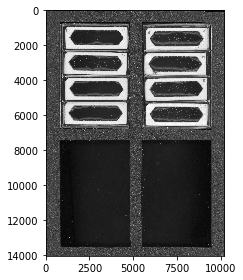

In [74]:
#Hardcode for the well that you would like to verify
prefix = 'LRH_200810'
suffix = '002'
plate_id = '5'
well_id = 'R'
slot_id = 1

## Load the images
fin_img = load_image_data(image_location, prefix, suffix)
#pre_aligned, h = alignImages(fin_image, pre_image)

io.imshow(fin_img)

1
<class 'int'>


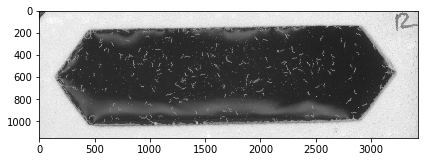

In [75]:
fin_cropped_2plate = crop_to_one_plate(fin_img, slot_id) 

fin_cropped_2well = left_crop_to_one_well(fin_cropped_2plate, well_id) 

io.imshow(fin_cropped_2well)

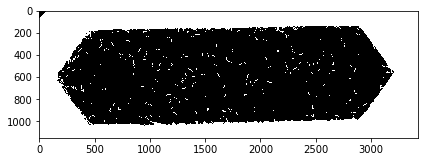

In [76]:
thresh = filters.threshold_li(fin_cropped_2well)

mask = fin_cropped_2well > thresh

io.imshow(mask)


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  This is separate from the ipykernel package so we can avoid doing imports until


174


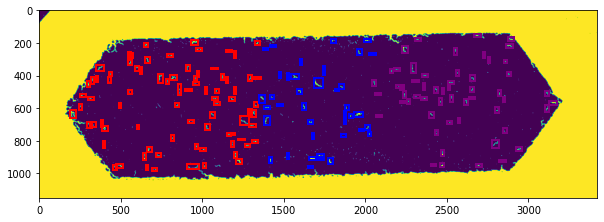

In [77]:
labeled_array, num_features = ndi.label(mask)
all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_cropped_2well,
                                  coordinates='rc')

## Filter features
filtered_regions = []
for region in all_regions:
    area = region.area
    if area >=90 and area <=1000 and region.major_axis_length < 150:
        filtered_regions.append(region)

props = ['area', 'convex_area', 'bbox', 'centroid']
region_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in filtered_regions])


            
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(mask)

left_area_boundary = int(2*mask.shape[1]/5)
right_area_boundary = int(3 * (mask.shape[1] / 5))
left_side_worms = region_df[[centroid[1] <= left_area_boundary 
                                    for centroid in region_df['centroid']]]
middle_worms = region_df[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
                                 for centroid in region_df['centroid']]]
right_side_worms = region_df[[centroid[1] > right_area_boundary 
                                     for centroid in region_df['centroid']]]


for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

for index, row in middle_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    
for index, row in right_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='purple', linewidth=2)
    ax.add_patch(rect)


print(len(region_df))